In [129]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

## Importing the Dataset

In [130]:
df = pd.read_csv("final_df.csv")
df.head()

,Hotels,Ratings,Price,Promotion,Description,Link,Place,From Date,To Day
0,Casa Abamita,8.5,€ 740,Only 1 room left at this price on our site,Double or Twin Room Without Views - Disability...,https://www.booking.com/hotel/es/mayerling-aba...,Barcelona,2024-05-23,2024-05-26
1,Le Palacete powered by Sonder,8.1,€ 925,Only 1 room left at this price on our site,King Room\n1 extra-large double bed\nOnly 1 ro...,https://www.booking.com/hotel/es/le-palacete.e...,Barcelona,2024-05-23,2024-05-26
2,Motel One Barcelona-Ciutadella,8.8,€ 605,NaN,Double Room\n1 double bed\nFree cancellation\n...,https://www.booking.com/hotel/es/motel-one-bar...,Barcelona,2024-05-23,2024-05-26
3,TWO Hotel Barcelona by Axel 4* Sup- Adults Only,8.4,€ 610,NaN,Double or Twin Room\n1 large double bed\n3 nig...,https://www.booking.com/hotel/es/two-barcelona...,Barcelona,2024-05-23,2024-05-26
4,Inside Barcelona Apartments Sants,8.6,€ 494,NaN,Studio (2 Adults)\nEntire apartment • 1 bedroo...,https://www.booking.com/hotel/es/inside-bcn-ap...,Barcelona,2024-05-23,2024-05-26


Converting Prices to Integers.

In [131]:
df['Price'] = df['Price'].replace('[^0-9]', '', regex=True)
df.dropna(subset=['Price'], inplace=True)

df['Price'] = df['Price'].astype(int)

Dates are binary encoded:  
1 is for the weekend of Primavera  
0 is our control weekend  

Binary encoding for cities:  
1 is for Barcelona  
0 is for Valencia  

In [132]:

dates = df["From Date"].unique()
date_mapping, date_index = pd.factorize(df["From Date"])

df["From Date"] = date_mapping

In [133]:
df["Place"] = 1 - pd.get_dummies(data =  df["Place"], columns = "Place", drop_first= True, dtype = int)

In [134]:
df = df.drop(["Link", "Hotels", "To Day"], axis = 1)

## Descriptive Statistics

# Regressions

## Barcelona: Primavera vs Weekend Before

In [135]:
Regress1 = df[df["Place"] == 1][["From Date", "Price"]]
Regress1

,From Date,Price
0,0,740
1,0,925
2,0,605
3,0,610
4,0,494
...,...,...
2001,1,2561
2002,1,2370
2003,1,3974
2004,1,3786


In [136]:
Regress1[Regress1["From Date"] == 1]["Price"].mean() - Regress1[Regress1["From Date"] == 0]["Price"].mean()



497.10004920452684

In [137]:
lr = LinearRegression()
lr.fit(Regress1[["From Date"]], Regress1["Price"])

LinearRegression()

In [138]:
b = lr.intercept_
m = lr.coef_

print(f'Intercept (Average Price of Control Group): ${round(b, 2)}')
print(f'Slope (Effect Estimate): ${round(m[0], 2)}')

Intercept (Average Price of Control Group): $809.54
Slope (Effect Estimate): $497.1


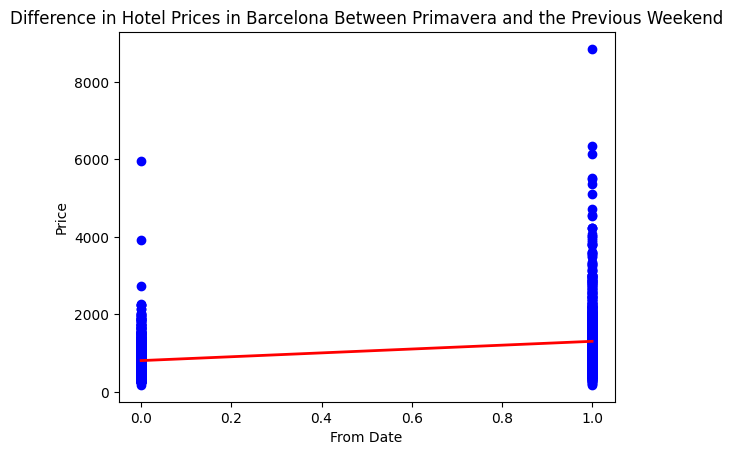

In [139]:
plt.scatter(Regress1["From Date"], Regress1["Price"], color='blue', label='Data')
plt.plot(Regress1["From Date"], lr.predict(Regress1[["From Date"]]), color='red', linewidth=2, label='Regression Line')
plt.xlabel('From Date')
plt.ylabel('Price')
plt.title("Difference in Hotel Prices in Barcelona Between Primavera and the Previous Weekend")
plt.show()

## Primavera Weekend: Valencia vs Barcelona

In [143]:
Regress2 = df[df["From Date"] == 0]

In [161]:
y = Regress2["Price"]
X = Regress2[["Place"]]

lr.fit(X,y)

LinearRegression()

In [164]:
b = lr.intercept_
m = lr.coef_

print(f'Intercept (Average Price of Control Group): ${round(b, 2)}')
print(f'Slope (Effect Estimate): ${round(m[0], 2)}')

Intercept (Average Price of Control Group): $631.93
Slope (Effect Estimate): $177.61
